In [0]:
import re
import nltk
import pickle
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
!python -m nltk.downloader stopwords wordnet punkt averaged_perceptron_tagger
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.layers import Attention
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import RMSprop
from sklearn.model_selection import train_test_split
!pip install rouge
from rouge import Rouge

/usr/lib/python3.6/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### Hyperparameters

In [0]:
BATCH_SIZE=40
EPOCHS=50
LATENT_DIM=128
EMBEDDING_DIM=300 #50,100,200,300
TEST_TRAIN_SPLIT=0.15
LEARNING_RATE=0.001
PATH=""
FILE_NAME="all.csv"
MAX_TEXT_LEN = 30
MAX_SUMMARY_LEN = 10
UNCOMMON_WORD_THRESHOLD = 100
# system booleans
COLAB=True # true if running on colab
build_number="1"

In [0]:
# create rouge object for evaluation
rouge = Rouge()

## Data Processing

Read In Data

In [0]:
# Only needed if running on Google Colab
if COLAB:
  from google.colab import drive
  drive.mount('/content/drive')
  PATH = "./drive/My Drive/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
df = pd.read_csv(PATH + FILE_NAME)

In [0]:
df.count

<bound method DataFrame.count of        Unnamed: 0  ...                                            summary
0               0  ...  Harry Potter star Daniel Radcliffe gets 20M fo...
1               1  ...  Mentally ill inmates Miami housed forgotten fl...
2               2  ...  NEW I thought I going die driver says Man says...
3               3  ...  Five small polyps found procedure none worriso...
4               4  ...  NEW NFL chief Atlanta Falcons owner critical M...
...           ...  ...                                                ...
92574       92574  ...  Cape Town students demand Cecil Rhodes statue ...
92575       92575  ...  More people displaced live Moscow people lost ...
92576       92576  ...  Dzhokhar Tsarnaev trial alleged role Boston Ma...
92577       92577  ...  Rabea Dardunas Gaza home destroyed last year s...
92578       92578  ...  Saudi minister If wars drums beaten ready U.N....

[92579 rows x 4 columns]>

In [0]:
df.head()

,Unnamed: 0,file,text,summary
0,0,42c027e4ff9730fbb3de84c1af0d2c506e41c3e4.story,LONDON England Reuters Harry Potter star Danie...,Harry Potter star Daniel Radcliffe gets 20M fo...
1,1,ee8871b15c50d0db17b0179a6d2beab35065f1e9.story,Editors note In Behind Scenes series CNN corre...,Mentally ill inmates Miami housed forgotten fl...
2,2,06352019a19ae31e527f37f7571c6dd7f0c5da37.story,MINNEAPOLIS Minnesota Drivers Minneapolis brid...,NEW I thought I going die driver says Man says...
3,3,24521a2abb2e1f5e34e6824e0f9e56904a2b0e88.story,WASHINGTON Doctors remove five small polyp Pre...,Five small polyps found procedure none worriso...
4,4,7fe70cc8b12fab2d0a258fababf7d9c6b5e1262a.story,The National Football League indefinitely susp...,NEW NFL chief Atlanta Falcons owner critical M...


Remove .'s that appear in stuff like U.S.A and U.N - Eventually need to move this to dataprocessing.py

In [0]:
print(df['summary'][0])
df['summary'] = df['summary'].apply(lambda x: re.sub(r'\..*$',' ',str(x)))
print(df['summary'][0])

Harry Potter star Daniel Radcliffe gets 20M fortune turns 18 Monday Young actor says plans fritter cash away Radcliffes earnings first five Potter films held trust fund
Harry Potter star Daniel Radcliffe gets 20M fortune turns 18 Monday Young actor says plans fritter cash away Radcliffes earnings first five Potter films held trust fund


In [0]:
print(df['summary'][0])
df['summary'] = df['summary'].apply(lambda x: re.sub(r'\.','',str(x)))
print(df['summary'][0])

Harry Potter star Daniel Radcliffe gets 20M fortune turns 18 Monday Young actor says plans fritter cash away Radcliffes earnings first five Potter films held trust fund
Harry Potter star Daniel Radcliffe gets 20M fortune turns 18 Monday Young actor says plans fritter cash away Radcliffes earnings first five Potter films held trust fund


Check for rows with null values in them, and copy these into a new dataframe (df1). Drop any rows in df1 from df to ensure no NaN valued rows are present/

*Note. using simply dropna(how='any') does not seem to drop any of the rows*

In [0]:
print(df.isnull().values.any())
print(df.shape)

df1 = df[df.isna().any(axis=1)]
print(df1.shape)

df.drop(df1.index, axis=0,inplace=True)
print(df.shape)
print(df.isnull().values.any())

True
(92579, 4)
(114, 4)
(92465, 4)
False


Cut down text to MAX_TEXT_LEN words, and summaries to MAX_SUMMARY_LEN

In [0]:
print(df['text'][0])
df['text'] = df['text'].apply(lambda x: nltk.word_tokenize(x)).apply(lambda x: " ".join(x[:MAX_TEXT_LEN]))
print(df['text'][0])

LONDON England Reuters Harry Potter star Daniel Radcliffe gain access report 20 million 411 million fortune turn 18 Monday insists money wont cast spell Daniel Radcliffe Harry Potter Harry Potter Order Phoenix To disappointment gossip columnist around world young actor say plan fritter cash away fast car drink celebrity party I dont plan one people soon turn 18 suddenly buy massive sport car collection something similar told Australian interviewer earlier month I dont think Ill particularly extravagant The thing I like buying thing cost 10 pound book CDs DVDs At 18 Radcliffe able gamble casino buy drink pub see horror film Hostel Part II currently six place number one movie UK box office chart Details hell mark landmark birthday wrap His agent publicist comment plan Ill definitely sort party say interview Hopefully none reading Radcliffes earnings first five Potter film held trust fund able touch Despite grow fame rich actor say keep foot firmly ground People always look say kid star g

In [0]:
print(df['summary'][0])
df['summary'] = df['summary'].apply(lambda x: nltk.word_tokenize(x)).apply(lambda x: " ".join(x[:MAX_SUMMARY_LEN]))
print(df['summary'][0])

Harry Potter star Daniel Radcliffe gets 20M fortune turns 18 Monday Young actor says plans fritter cash away Radcliffes earnings first five Potter films held trust fund
Harry Potter star Daniel Radcliffe gets 20M fortune turns 18


Word Count Distribution

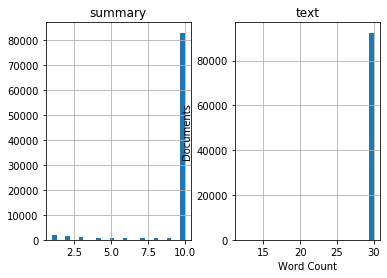

In [0]:
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in df['text']:
      text_word_count.append(len(i.split(' ')))

for i in df['summary']:
      summary_word_count.append(len(i.split(' ')))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.ylabel('Documents')
plt.xlabel('Word Count')
# plt.savefig('word_count_distro' + str(build_number) + '.png')
plt.show()

Text

In [0]:
x_word_dict = {}
text = df['text'].apply(lambda x: nltk.word_tokenize(x))

for index, row in text.iteritems():
  for word in row:
    if word not in x_word_dict.keys():
      x_word_dict[word] = 1
    else:
      x_word_dict[word] += 1

print(len(x_word_dict))
sorted_dict = sorted(x_word_dict.items(), key=lambda x: x[1], reverse=True)
print(sorted_dict)
x, y = zip(*sorted_dict)

96790
[('The', 41696), ('say', 28819), ('A', 14745), ('year', 11842), ('one', 10166), ('US', 9083), ('people', 8707), ('two', 8085), ('I', 7851), ('New', 7716), ('Tuesday', 7556), ('first', 7421), ('new', 7357), ('Wednesday', 7237), ('week', 7069), ('Thursday', 7061), ('take', 7034), ('Monday', 6911), ('President', 6881), ('make', 6750), ('Friday', 6597), ('day', 6550), ('world', 6458), ('official', 6405), ('kill', 6314), ('last', 6124), ('In', 5852), ('country', 5838), ('time', 5836), ('police', 5833), ('But', 5346), ('Washington', 5321), ('Sunday', 5261), ('report', 5130), ('go', 5047), ('accord', 5000), ('United', 4975), ('Saturday', 4901), ('CNN', 4875), ('come', 4754), ('man', 4736), ('get', 4646), ('show', 4567), ('government', 4509), ('woman', 4488), ('It', 4430), ('call', 4408), ('Obama', 4383), ('York', 4340), ('month', 4328), ('would', 4142), ('state', 4120), ('home', 4117), ('death', 4094), ('told', 4043), ('former', 3972), ('know', 3968), ('three', 3951), ('charge', 3783), 

In [0]:
# only accept words that occur more than UNCOMMON_WORD_THR times
accept_words = []
for word, occ in sorted_dict:
  if int(occ) > UNCOMMON_WORD_THRESHOLD:
    accept_words.append(word)
  else:
    break
     
#remove uncommon words
accept_words = [x.lower() for x in accept_words]
print(accept_words)
print(df['text'][2])
df['text'] = df['text'].apply(lambda x: nltk.word_tokenize(x)).apply(lambda x: " ".join([word for word in x if word.lower() in accept_words]))
print(df['text'][2])

['the', 'say', 'a', 'year', 'one', 'us', 'people', 'two', 'i', 'new', 'tuesday', 'first', 'new', 'wednesday', 'week', 'thursday', 'take', 'monday', 'president', 'make', 'friday', 'day', 'world', 'official', 'kill', 'last', 'in', 'country', 'time', 'police', 'but', 'washington', 'sunday', 'report', 'go', 'accord', 'united', 'saturday', 'cnn', 'come', 'man', 'get', 'show', 'government', 'woman', 'it', 'call', 'obama', 'york', 'month', 'would', 'state', 'home', 'death', 'told', 'former', 'know', 'three', 'charge', 'city', 'die', 'like', 'attack', 'group', 'announce', 'could', 'found', 'american', 'south', 'authority', 'use', 'million', 'release', 'family', 'may', 'life', 'work', 'night', 'states', 'california', 'child', 'its', 'leader', 'arrest', 'military', 'he', 'late', 'many', 'back', 'look', 'end', 'since', 'see', 'london', 'become', 'force', 'world', 'barack', 'court', 'least', 'face', 'give', 'lead', 'way', 'include', 'as', 'help', 'right', 'ago', 'part', 'even', 'team', 'nation', '

In [0]:
x_word_dict_after = {}
text = df['text'].apply(lambda x: nltk.word_tokenize(x))

for index, row in text.iteritems():
  for word in row:
    if word not in x_word_dict_after.keys():
      x_word_dict_after[word] = 1
    else:
      x_word_dict_after[word] += 1

print(len(x_word_dict_after))

6635


Summaries

In [0]:
y_word_dict = {}
summary = df['summary'].apply(lambda x: nltk.word_tokenize(x))

for index, row in summary.iteritems():
  for word in row:
    if word not in y_word_dict.keys():
      y_word_dict[word] = 1
    else:
      y_word_dict[word] += 1

print(len(y_word_dict))
sorted_dict = sorted(y_word_dict.items(), key=lambda x: x[1], reverse=True)
print(sorted_dict)
x, y = zip(*sorted_dict)

67110
[('The', 16050), ('says', 11825), ('NEW', 11300), ('A', 4773), ('U', 4626), ('He', 3154), ('say', 3070), ('new', 2586), ('people', 2487), ('Obama', 2348), ('New', 2291), ('first', 2198), ('President', 1906), ('two', 1748), ('one', 1738), ('years', 1646), ('police', 1625), ('killed', 1553), ('She', 1399), ('Police', 1385), ('CNN', 1371), ('World', 1282), ('found', 1263), ('It', 1232), ('In', 1169), ('show', 1164), ('said', 1128), ('death', 1117), ('year', 1093), ('South', 1050), ('last', 1050), ('official', 1020), ('man', 1013), ('world', 982), ('died', 975), ('president', 950), ('government', 940), ('Two', 936), ('I', 935), ('could', 914), ('One', 912), ('This', 912), ('group', 901), ('three', 899), ('home', 886), ('time', 875), ('help', 875), ('United', 863), ('family', 861), ('10', 854), ('officials', 852), ('Some', 847), ('They', 847), ('John', 830), ('since', 815), ('million', 813), ('An', 809), ('least', 807), ('arrested', 793), ('Cup', 787), ('week', 785), ('House', 780), (

In [0]:
# only accept words that occur more than 100 times
accept_words = []
for word, occ in sorted_dict:
  if int(occ) > UNCOMMON_WORD_THRESHOLD:
    accept_words.append(word)
  else:
    break
     
#remove first three comon words
# accept_words.remove(list(x[:3]))
accept_words = [x.lower() for x in accept_words]
print(accept_words)
print(df['summary'][2])
df['summary'] = df['summary'].apply(lambda x: nltk.word_tokenize(x)).apply(lambda x: " ".join([word for word in x if word.lower() in accept_words]))
print(df['summary'][2])

['the', 'says', 'new', 'a', 'u', 'he', 'say', 'new', 'people', 'obama', 'new', 'first', 'president', 'two', 'one', 'years', 'police', 'killed', 'she', 'police', 'cnn', 'world', 'found', 'it', 'in', 'show', 'said', 'death', 'year', 'south', 'last', 'official', 'man', 'world', 'died', 'president', 'government', 'two', 'i', 'could', 'one', 'this', 'group', 'three', 'home', 'time', 'help', 'united', 'family', '10', 'officials', 'some', 'they', 'john', 'since', 'million', 'an', 'least', 'arrested', 'cup', 'week', 'house', 'state', 'american', 'north', 'at', 'report', 'calls', 'david', 'china', 'would', 'no', 'win', 'made', 'former', 'michael', 'former', 'may', 'attack', 'court', 'accused', 'more', 'british', 'york', 'transcript', 'wins', 'shows', 'military', 'its', 'women', 'dead', 'set', 'sunday', 'top', 'woman', 'back', 'monday', 'second', 'we', 'children', 'four', 'take', 'video', 'friday', 'get', 'leader', '20', 'there', 'media', 'charged', 'tells', 'tuesday', 'case', 'many', 'make', 's

In [0]:
y_word_dict_after = {}
summary = df['summary'].apply(lambda x: nltk.word_tokenize(x))

for index, row in summary.iteritems():
  for word in row:
    if word not in y_word_dict_after.keys():
      y_word_dict_after[word] = 1
    else:
      y_word_dict_after[word] += 1
print(len(y_word_dict_after))

2534


Max Lengths after Word Removal

In [0]:
print(df.isnull().values.any())
print(df.shape)

df1 = df[df.isna().any(axis=1)]
print(df1.shape)

df.drop(df1.index, axis=0,inplace=True)
print(df.shape)
print(df.isnull().values.any())

False
(92465, 4)
(0, 4)
(92465, 4)
False


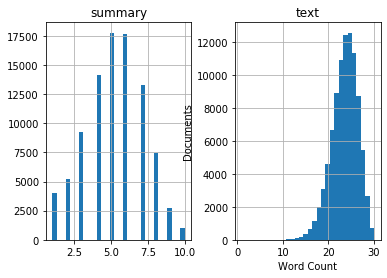

In [0]:
# Max lengths after removal of words
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in df['text']:
      text_word_count.append(len(i.split(' ')))

for i in df['summary']:
      summary_word_count.append(len(i.split(' ')))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.ylabel('Documents')
plt.xlabel('Word Count')
# plt.savefig('word_count_distro_removed_model' + str(build_number) + '.png')
plt.show()

Max Text Lengths

In [0]:
MAX_TEXT_LEN = max([len(txt.split(' ')) for txt in df['text']])
MAX_SUMMARY_LEN = max([len(txt.split(' ')) for txt in df['summary']])
print(MAX_TEXT_LEN)
print(MAX_SUMMARY_LEN)

30
10


### Training-Validation Split

X - Articles text </br>
Y - Summaries

In [0]:
# convert to numpy array
X = np.array(df['text'][:8000])
Y = np.array(df['summary'][:8000])

In [0]:
x_tr,x_val,y_tr,y_val=train_test_split(X,Y,test_size=TEST_TRAIN_SPLIT,random_state=0,shuffle=True)
print(x_tr.shape)
print(x_val.shape)
print(y_tr.shape)
print(y_val.shape)

(6800,)
(1200,)
(6800,)
(1200,)


## GloVe

In [0]:
embedding_index = {}
with open('./drive/My Drive/glove/glove.6B.' + str(EMBEDDING_DIM) + 'd.txt') as f:
  for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embedding_index[word] = coefs


In [0]:
print(len(embedding_index))

400000


In [0]:
print(embedding_index.get("us"))

[-2.2629e-03 -4.0326e-01 -1.3662e-01 -4.7524e-02 -2.1565e-01  1.0941e-02
 -7.1686e-01  2.2679e-01  1.9262e-01 -2.3677e+00 -1.2620e-01 -2.8585e-01
  1.2318e-01 -3.6485e-01 -1.9763e-02  5.0293e-01 -3.5194e-01 -4.0365e-01
 -2.3360e-02 -3.4709e-01 -2.2936e-01  3.1085e-01  5.8753e-01 -1.5865e-01
  1.5788e-01  2.4707e-01 -1.9152e-02  5.8994e-01  5.4938e-01  5.1962e-01
 -1.7794e-01 -2.3054e-02 -4.5692e-01  1.6926e-01 -8.0411e-01 -3.1563e-01
  1.6063e-01 -1.5277e-01  2.5275e-02 -7.8255e-02 -3.3299e-01 -6.5220e-01
 -6.8773e-01  3.4908e-01  1.1963e-01  1.1163e-01  1.1593e-01 -2.5014e-01
  5.6591e-02  2.7721e-01 -4.2915e-01 -3.4347e-02 -4.9500e-01  2.1196e-01
 -3.5877e-01  3.5018e-01 -1.0159e-01  4.8608e-01  4.2086e-01 -3.2853e-01
 -4.2408e-01  1.8997e-01  5.0507e-01 -5.9435e-01 -1.8640e-01  8.3433e-02
 -4.5471e-02 -1.9213e-01 -1.9872e-01  2.5517e-01 -2.5580e-01  1.3898e-02
 -1.9325e-01  5.3387e-01  8.3175e-02 -7.3384e-02  2.4807e-01  3.0834e-01
 -3.3447e-01 -1.3687e-01 -1.1897e-01 -6.5299e-01  3

### Word Embeddings - Tokenization

X Tokenizer

In [0]:
word_dict = {}
text = df['text'][:8000]

for row in text: 
  for word in row.split(" "):
    if word not in word_dict:
      word_dict[word] = 1
    else:
      word_dict[word] += 1

print(len(word_dict))

5323


In [0]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=len(word_dict), split=" ") 
x_tokenizer.fit_on_texts(list(X))

x_embedding_matrix = np.zeros(((x_tokenizer.num_words)+1, EMBEDDING_DIM),dtype='float32')
print(x_embedding_matrix.shape)
for word,i in x_tokenizer.word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        # Words not found in glove will be zeros
        x_embedding_matrix[i] = embedding_vector

(5324, 300)


In [0]:
# # #prepare a tokenizer for reviews on training data
# x_tokenizer = Tokenizer(num_words=len(word_dict), split=" ") 
# x_tokenizer.fit_on_texts(list(X))

# #convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=x_voc, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=x_voc, padding='post')

print(x_voc)

5324


In [0]:
print(x_tokenizer.num_words)
print(x_voc)

5323
5324


Y Tokenizer

In [0]:
y_word_dict = {}
summ = df['summary'][:8000]

for row in summ: 
  for word in row.split(" "):
    if word not in y_word_dict:
      y_word_dict[word] = 1
    else:
      y_word_dict[word] += 1

print(len(y_word_dict))

2171


In [0]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=len(y_word_dict), split=" ") 
y_tokenizer.fit_on_texts(list(Y))

y_embedding_matrix = np.zeros((x_tokenizer.num_words +1, EMBEDDING_DIM),dtype='float32')
print(y_embedding_matrix.shape)
print(len( y_tokenizer.word_index))
for word,i in y_tokenizer.word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
    # Words not found in glove will be zeros
        y_embedding_matrix[i] = embedding_vector

(5324, 300)
1436


In [0]:
#prepare a tokenizer for reviews on training data
# y_tokenizer = Tokenizer(num_words=len(y_word_dict), split=" ") 
# y_tokenizer.fit_on_texts(list(Y))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#size of vocabulary
y_voc  =   y_tokenizer.num_words + 1

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=x_voc, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=x_voc, padding='post')

print(y_voc)

2172


### GloVe Word Coverage

In [0]:
def coverage(dict, total):
  covered = 0
  for words, _ in dict.items():
    if embedding_index.get(word) is not None:
      covered += 1
  return (covered/total * 100)

text_total = len(word_dict)
text_covered = coverage(word_dict,text_total)

summ_total = len(y_word_dict)
summ_covered = coverage(y_word_dict,summ_total)

print("Original Text Coverage: " + str(text_covered) + "%")
print("Summary Coverage: " + str(summ_covered) + "%")

Original Text Coverage: 100.0%
Summary Coverage: 100.0%


## Learning Model

#### Encoder Model

In [0]:
# bidirectional encoder
encoder_inputs = Input(shape=(x_voc,))
# embedding layer
enc_emb_layer = Embedding(x_voc, EMBEDDING_DIM, weights=[x_embedding_matrix], 
                          input_length=x_voc, trainable=False)
enc_emb = enc_emb_layer(encoder_inputs)

#encoder lstm 
encoder_lstm = Bidirectional(LSTM(LATENT_DIM,return_sequences=True,return_state=True))
encoder_outputs, fw_state_h, fw_state_c, bw_state_h, bw_state_c = encoder_lstm(enc_emb)

state_h = Concatenate()([fw_state_h, bw_state_h])
state_c = Concatenate()([fw_state_c, bw_state_c])
encoder_states = [state_h, state_c]

#### Decoder Model

In [0]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(x_voc,))

#embedding layer
dec_emb_layer = Embedding(x_voc, EMBEDDING_DIM,
                          weights=[y_embedding_matrix], input_length=x_voc, 
                          trainable=False)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(LATENT_DIM*2, return_sequences=True, return_state=True)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb, initial_state=encoder_states)
                                                          
#dense layer
decoder_dense = Dense(y_voc, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

#### Combined LSTM Model

In [0]:
# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 5324)         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 5324, 300)    1597200     input_6[0][0]                    
__________________________________________________________________________________________________
input_7 (InputLayer)            (None, 5324)         0                                            
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) [(None, 5324, 256),  439296      embedding_3[0][0]                
____________________________________________________________________________________________

In [0]:
optimizer = RMSprop(lr=LEARNING_RATE, rho=0.9)

In [0]:
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy')

- Early Stopping Callback to ensure we stop when Validation Loss is lowest - minimises risk of overfitting
- Model Checkpoint saves the model after each epoch so that we can load the model with the best weights later on. Alternatively, it allows us to continue training the model at a later data



In [0]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2, restore_best_weights=False)
filepath = "./model/saved-model-{epoch:02d}.hdf5"
if COLAB:
  filepath = "./drive/My Drive/project-model/saved-model-{epoch:02d}.hdf5"
mc = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)

#### Use this method to train a new model. To continue training a previously trained model see below

In [0]:
print(x_tr.shape)
print(y_tr.shape)
print(y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1).shape)
print(y_val.reshape(y_val.shape[0],y_val.shape[1], 1).shape)
y_tr_3d = y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)
y_val_3d = y_val.reshape(y_val.shape[0],y_val.shape[1], 1)

(6800, 5324)
(6800, 5324)
(6800, 5324, 1)
(1200, 5324, 1)


In [0]:
history = model.fit([x_tr,y_tr], y_tr_3d, batch_size=10, epochs=EPOCHS, callbacks=[es],
                    validation_data=([x_val,y_val], y_val_3d))

Train on 6800 samples, validate on 1200 samples
Epoch 1/50
  10/6800 [..............................] - ETA: 4:45:27 - loss: 7.6834

KeyboardInterrupt: ignored

In [0]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
# plt.savefig('loss' + str(build_number) + '.png')
plt.show()

# Inference Model

In [0]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
print(reverse_source_word_index)
print(reverse_target_word_index)

In [0]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

In [0]:
encoder_model.summary()

In [0]:
# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(LATENT_DIM*2,))
decoder_state_input_c = Input(shape=(LATENT_DIM*2,))
decoder_hidden_state_input = Input(shape=(x_voc,LATENT_DIM*2))
decoder_state_inputs = [decoder_state_input_h, decoder_state_input_c]

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_state_inputs)
decoder_states = [state_h2, state_c2]
# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c], [decoder_outputs2] + decoder_states)
# decoder_model = Model([decoder_inputs] + decoder_state_inputs, [decoder_outputs2] + decoder_states)


In [0]:
decoder_model.summary()

### Methods for Reversing Word Embeddings

In [0]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

### Summarisation Method 

In [0]:
def decode_sequence(input_seq): 
    # Encode the input as state vectors.
    # print(input_seq)
    # print(input_seq.shape)
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, x_voc))
    # print(target_seq.shape)
    stop_condition = False
    decoded_sentence = ''
    last_token = 0
    while not stop_condition:
      # Model([decoder_inputs] + decoder_state_inputs, [decoder_outputs2] + decoder_states)
      output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c]) 
      sampled_token_index = np.argmax(output_tokens[0, -1, :][1:])
      # if(sampled_token_index == last_token):
      #   a = np.delete(output_tokens[0, -1, :][1:], sampled_token_index)
      #   sampled_token_index=np.argmax(a)
      #   if sampled_token_index >= last_token :
      #     sampled_token_index = sampled_token_index+1 
      # print(sampled_token_index)
      # print(sampled_token_index)
      # last_token = sampled_token_index
      if (sampled_token_index != 0 ):
        sampled_token = reverse_target_word_index[sampled_token_index]
        # print(sampled_token)
        decoded_sentence += ' '+sampled_token
      else :
        print("sadface")
        stop_condition = True
      if (len(decoded_sentence.split()) >= (MAX_SUMMARY_LEN-1)):
              stop_condition = True
       # Update the target sequence (of length 1).
      # target_seq = np.zeros((1,1))
      target_seq = np.zeros((1, x_voc))
      target_seq[0, sampled_token_index] = 1
      # print(target_seq)
      # Update internal states
      e_h, e_c = h, c
      
    return decoded_sentence

## Test Model Output

In [0]:
def getRouge(gt, pred):
  return rouge.get_scores(pred, gt)

In [0]:
for i in range(0,4):
    print("Article:",seq2text(x_tr[i]))
    original = seq2summary(y_tr[i])
    if original != "":
      print("Original summary:",original)
      x_tr_i_reshaped = x_tr[i].reshape(1,x_voc)
      summary = decode_sequence(x_tr_i_reshaped)
      print("Generated summary:",summary)
      print("\n")

      if summary != "":    
        print("ROUGE score: ")
        score = getRouge(str(summary), str(original))
        print(score)
        print(score[0].get('rouge-1').get('f'))
        print(score[0].get('rouge-1').get('p'))
        print(score[0].get('rouge-1').get('r'))

In [0]:
for i in range(80,100):
    print("Article:",seq2text(x_tr[i]))
    original = seq2summary(y_tr[i])
    print("Original summary:",original)
    x_tr_i_reshaped = x_tr[i].reshape(1,x_voc)
    summary = decode_sequence(x_tr_i_reshaped)
    print("Generated summary:",summary)
    print("\n")

    if summary != "":    
      print("ROUGE score: ")
      score = getRouge(str(summary), str(original))
      print(score)
      print(score[0].get('rouge-1').get('f'))
      print(score[0].get('rouge-1').get('p'))
      print(score[0].get('rouge-1').get('r'))